In [1]:
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
import graphviz

from IPython.display import Image

%matplotlib inline

# Load Data

In [2]:
data_train = np.loadtxt('svm-train.txt')
data_test = np.loadtxt('svm-test.txt')

In [3]:
x_train, y_train = data_train[:, 0: 2], data_train[:, 2].reshape(-1, 1)
x_test, y_test = data_test[:, 0: 2], data_test[:, 2].reshape(-1, 1)

In [4]:
# Change target to 0-1 label
y_train_label = np.array(list(map(lambda x: 1 if x > 0 else 0, y_train))).reshape(-1, 1)

# Decision Tree Class

# Q1

In [5]:
def compute_entropy(label_array):
    '''
    Calulate the entropy of given label list
    
    :param label_array: a numpy array of binary labels shape = (n, 1)
    :return entropy: entropy value
    '''
    # Your code goes here
    labels = np.unique(label_array)
    entropy = 0
    for label in labels:
        prob = np.sum(label_array==label)/float(len(label_array))
        entropy += -prob * np.log(prob)  
    return entropy

def compute_gini(label_array):
    '''
    Calulate the gini index of label list
    
    :param label_array: a numpy array of labels shape = (n, 1)
    :return gini: gini index value
    '''
    # Your code goes here
    labels = np.unique(label_array)
    gini = 0
    for label in labels:
        prob = np.sum(label_array==label)/len(label_array)
        gini += prob*(1-prob)
    return gini

# Q2

In [6]:
class Decision_Tree(BaseEstimator):
     
    def __init__(self, split_loss_function, leaf_value_estimator,
                 depth=0, min_sample=5, max_depth=10):
        '''
        Initialize the decision tree classifier

        :param split_loss_function: method with args (X, y) returning loss
        :param leaf_value_estimator: method for estimating leaf value from array of ys
        :param depth: depth indicator, default value is 0, representing root node
        :param min_sample: an internal node can be splitted only if it contains points more than min_smaple
        :param max_depth: restriction of tree depth.
        '''
        self.split_loss_function = split_loss_function
        self.leaf_value_estimator = leaf_value_estimator
        self.depth = depth
        self.min_sample = min_sample
        self.max_depth = max_depth
        self.is_leaf = False

        # add some attributes for later use
        self.value = None
        self.split_value = None
        self.split_id = None
        
        self.num_positive = None
        self.leaf_size = None
        self.left = None
        self.right = None
        
    def fit(self, x, y):
        '''
        This should fit the tree classifier by setting the values self.is_leaf, 
        self.split_id (the index of the feature we want to split on, if we're splitting),
        self.split_value (the corresponding value of that feature where the split is),
        and self.value, which is the prediction value if the tree is a leaf node.  If we are 
        splitting the node, we should also init self.left and self.right to be Decision_Tree
        objects corresponding to the left and right subtrees. These subtrees should be fit on
        the data that fall to the left and right,respectively, of self.split_value.
        This is a recurisive tree building procedure. 
        
        :param X: a numpy array of training data, shape = (n, m)
        :param y: a numpy array of labels, shape = (n, 1)

        :return self
        '''
        # Your code goes here
        
        num_samples = x.shape[0]
        
        ### remain it a leaf node
        if self.depth >= self.max_depth or num_samples <= self.min_sample:
            self.is_leaf = True
            self.value = self.leaf_value_estimator(y)
            self.leaf_size = x.shape[0]
            self.num_positive = np.sum(y)
            return self
  
        ### continue splitting the current node
        self.find_best_feature_split(x, y)
        x_left_index = np.where(x[:, self.split_id]<=self.split_value)[0]
        x_right_index = np.where(x[:, self.split_id]>self.split_value)[0]
        
        x_left = x[x_left_index, :].reshape(-1, x.shape[1])
        x_right = x[x_right_index, :].reshape(-1, x.shape[1])
        y_left = y[x_left_index, 0].reshape(-1, 1)
        y_right = y[x_right_index, 0].reshape(-1, 1)
        
        self.left = Decision_Tree(self.split_loss_function, 
                                  self.leaf_value_estimator, 
                                  depth=self.depth+1, 
                                  min_sample=self.min_sample, 
                                  max_depth=self.max_depth).fit(x_left, y_left)
        self.right = Decision_Tree(self.split_loss_function, 
                                   self.leaf_value_estimator, 
                                   depth=self.depth+1, 
                                   min_sample=self.min_sample, 
                                   max_depth=self.max_depth).fit(x_right, y_right)
        
        return self
        
    def find_best_split(self, x_node, y_node, feature_id):
        '''
        For feature number feature_id, returns the optimal splitting point 
        for data X_node, y_node, and corresponding loss
        :param X: a numpy array of training data, shape = (n_node)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        # Your code
        
        ### sort values of the feature_id'th feature
        split_value_arr = np.unique(x_node[:, feature_id])
        len_split_value = len(split_value_arr)
        split_value_sorted_arr = np.sort(split_value_arr)

        
        ### take n-1 split points halfway between the n adjacent values
        threshhold_lst = []
        for split_index in range(len_split_value-1):
            threshhold_lst.append(1/2*(split_value_arr[split_index]+split_value_arr[split_index+1]))
        
        
        ### enumerate n-1 split points for each feature 
        best_split_value = None
        best_loss = float('inf')
        num_samples = x_node.shape[0]
        for thresh in threshhold_lst:
            x_left_index = np.where(x_node[:, feature_id]<=thresh)[0]
            x_right_index = np.where(x_node[:, feature_id]>thresh)[0]
            if x_left_index.shape[0]==0 or x_right_index.shape[0]==0:
                continue    
            # calculate the loss and update best_loss if the current loss is smaller
            y_left = y_node[x_left_index, 0].reshape(-1, 1)
            y_right = y_node[x_right_index, 0].reshape(-1, 1)
            loss_left = self.split_loss_function(y_left)
            loss_right = self.split_loss_function(y_right)
            num_samples_left = y_left.shape[0]
            num_samples_right = y_right.shape[0]
            loss = num_samples_left/num_samples * loss_left + num_samples_right/num_samples * loss_right
            if loss < best_loss:
                best_loss = loss
                best_split_value = thresh
        split_value = best_split_value

        return split_value, best_loss

    def find_best_feature_split(self, x_node, y_node):
        '''
        Returns the optimal feature to split and best splitting point 
        for data X_node, y_node.
        :param X: a numpy array of training data, shape = (n_node, 1)
        :param y: a numpy array of labels, shape = (n_node, 1)
        '''
        # Your code
        
        if x_node.shape[1] == 1: 
            self.split_id = 0
            split_value, best_loss = self.find_best_split(x_node, y_node, 0)
            self.split_value = split_value
        else: 
            split_value_lst = []
            best_loss_lst = []
            feature_id_lst = list(range(x_node.shape[1]))
            for feature_id in feature_id_lst:
                split_value, best_loss = self.find_best_split(x_node, y_node, feature_id)
                split_value_lst.append(split_value)
                best_loss_lst.append(best_loss) 
            best_loss_index = np.argmin(best_loss_lst)
            self.split_id = feature_id_lst[best_loss_index]
            self.split_value = split_value_lst[best_loss_index]            
            self.num_positive = np.where(y_node[:, 0]==1)[0].shape[0]
            self.leaf_size = x_node.shape[0]
            
    def predict_instance(self, instance):
        '''
        Predict label by decision tree

        :param instance: a numpy array with new data, shape (1, m)

        :return whatever is returned by leaf_value_estimator for leaf containing instance
        '''
        if self.is_leaf:
            return self.value
        if instance[self.split_id] <= self.split_value:
            return self.left.predict_instance(instance)
        else:
            return self.right.predict_instance(instance)

# Decision Tree Classifier

In [7]:
def most_common_label(y):
    '''
    Find most common label
    '''
    label_cnt = Counter(y.reshape(len(y)))
    label = label_cnt.most_common(1)[0][0]
    return label

In [8]:
class Classification_Tree(BaseEstimator, ClassifierMixin):

    loss_function_dict = {
        'entropy': compute_entropy,
        'gini': compute_gini
    }

    def __init__(self, loss_function='entropy', min_sample=5, max_depth=10):
        '''
        :param loss_function(str): loss function for splitting internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  most_common_label,
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Decision Tree Boundary

# Q3

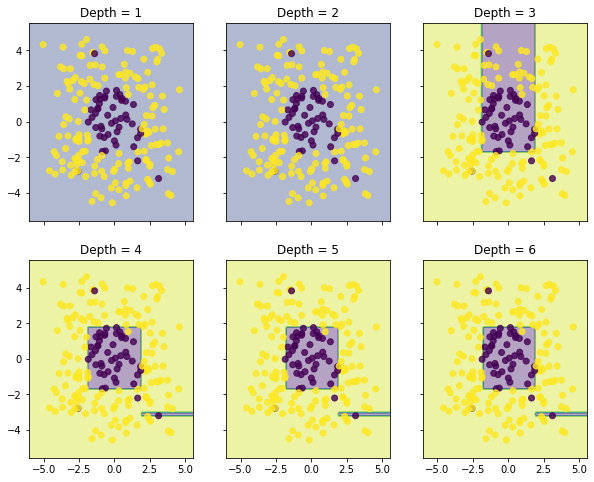

In [9]:
# Training classifiers with different depth
clf1 = Classification_Tree(max_depth=1, min_sample=2)
clf1.fit(x_train, y_train_label)

clf2 = Classification_Tree(max_depth=2, min_sample=2)
clf2.fit(x_train, y_train_label)

clf3 = Classification_Tree(max_depth=3, min_sample=2)
clf3.fit(x_train, y_train_label)

clf4 = Classification_Tree(max_depth=4, min_sample=2)
clf4.fit(x_train, y_train_label)

clf5 = Classification_Tree(max_depth=5, min_sample=2)
clf5.fit(x_train, y_train_label)

clf6 = Classification_Tree(max_depth=6, min_sample=2)
clf6.fit(x_train, y_train_label)

# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    Z = np.array([clf.predict_instance(x) for x in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(x_train[:, 0], x_train[:, 1], c=y_train_label[:,0], alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

# Compare decision tree with tree model in sklearn

In [10]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=2)
clf.fit(x_train, y_train_label)
export_graphviz(clf, out_file='tree_classifier.dot')

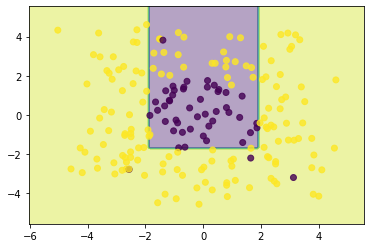

In [11]:
# Plotting decision regions
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = np.array([clf.predict(x[np.newaxis,:]) for x in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)
plt.figure()
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(x_train[:, 0], x_train[:, 1], 
c = y_train_label[:,0], alpha=0.8)

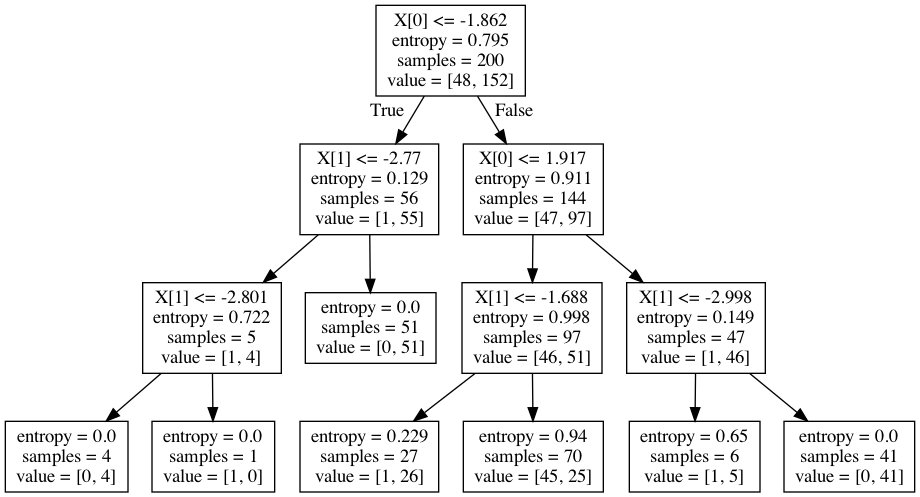

In [12]:
# Visualize decision tree
!dot -Tpng tree_classifier.dot -o tree_classifier.png
Image(filename='tree_classifier.png')

# Decision Tree Regressor

# Q4

In [25]:
# Regression Tree Specific Code
def mean_absolute_deviation_around_median(y):
    '''
    Calulate the mean absolute deviation around the median of a given target list
    
    :param y: a numpy array of targets shape = (n, 1)
    :return mae
    '''
    
    # Your code goes here
   
    mae = np.mean(np.abs(y-np.median(y)))
    return mae

In [26]:
class Regression_Tree():
    '''
    :attribute loss_function_dict: dictionary containing the loss functions used for splitting
    :attribute estimator_dict: dictionary containing the estimation functions used in leaf nodes
    '''

    loss_function_dict = {
        'mse': np.var,
        'mae': mean_absolute_deviation_around_median
    }

    estimator_dict = {
        'mean': np.mean,
        'median': np.median
    }
    
    def __init__(self, loss_function='mse', estimator='mean', min_sample=5, max_depth=10):
        '''
        Initialize Regression_Tree
        :param loss_function(str): loss function used for splitting internal nodes
        :param estimator(str): value estimator of internal node
        '''

        self.tree = Decision_Tree(self.loss_function_dict[loss_function],
                                  self.estimator_dict[estimator],
                                  0, min_sample, max_depth)

    def fit(self, X, y=None):
        self.tree.fit(X,y)
        return self

    def predict_instance(self, instance):
        value = self.tree.predict_instance(instance)
        return value

# Fit regression tree to one-dimensional regression data

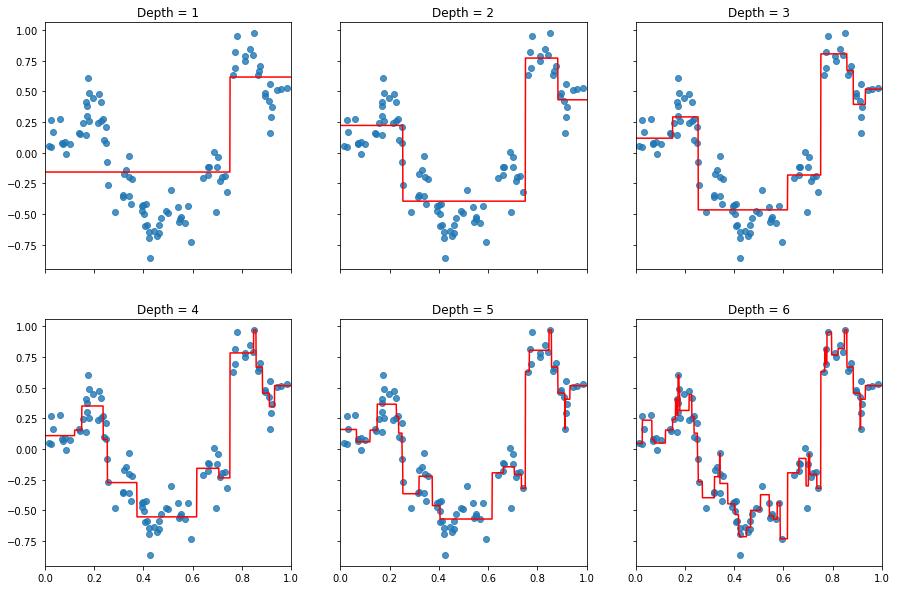

In [27]:
data_krr_train = np.loadtxt('krr-train.txt')
data_krr_test = np.loadtxt('krr-test.txt')
x_krr_train, y_krr_train = data_krr_train[:,0].reshape(-1,1), data_krr_train[:,1].reshape(-1,1)
x_krr_test, y_krr_test = data_krr_test[:,0].reshape(-1,1), data_krr_test[:,1].reshape(-1,1)

# Training regression trees with different depth
clf1 = Regression_Tree(max_depth=1,  min_sample=3, loss_function='mae', estimator='mean')
clf1.fit(x_krr_train, y_krr_train)

clf2 = Regression_Tree(max_depth=2,  min_sample=3, loss_function='mae', estimator='mean')
clf2.fit(x_krr_train, y_krr_train)

clf3 = Regression_Tree(max_depth=3,  min_sample=3, loss_function='mae', estimator='mean')
clf3.fit(x_krr_train, y_krr_train)

clf4 = Regression_Tree(max_depth=4,  min_sample=3, loss_function='mae', estimator='mean')
clf4.fit(x_krr_train, y_krr_train)

clf5 = Regression_Tree(max_depth=5,  min_sample=3, loss_function='mae', estimator='mean')
clf5.fit(x_krr_train, y_krr_train)

clf6 = Regression_Tree(max_depth=10,  min_sample=3, loss_function='mae', estimator='mean')
clf6.fit(x_krr_train, y_krr_train)

plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        [clf1, clf2, clf3, clf4, clf5, clf6],
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict_instance(x) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

# Compare with scikit-learn for debugging

In [28]:
max_depth_lst = list(range(1, 7))
clf_lst = []
for max_depth in max_depth_lst:
    clf = DecisionTreeRegressor(criterion='mae', 
                                max_depth=max_depth, 
                                min_samples_split=3).fit(x_krr_train, y_krr_train)
    clf_lst.append(clf)

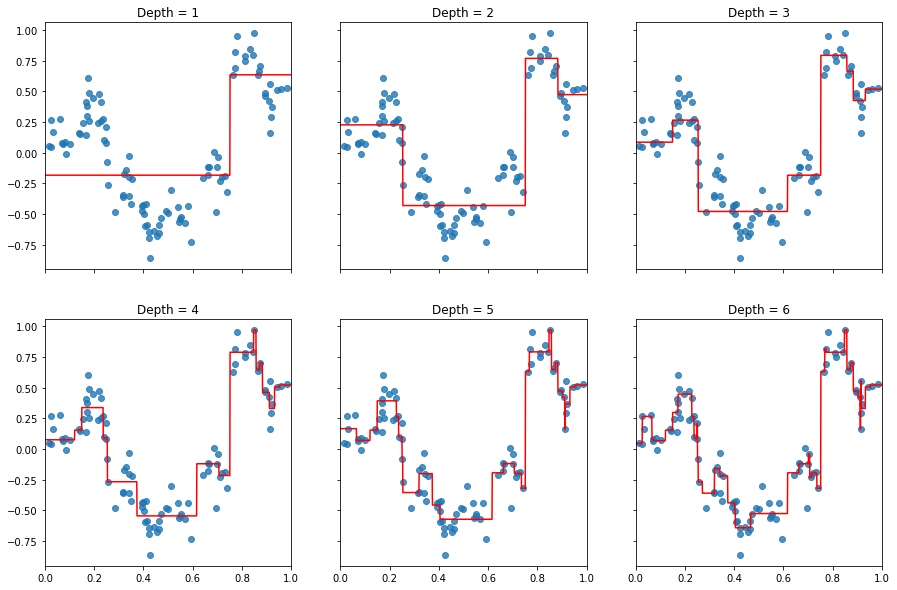

In [29]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, clf, tt in zip(product([0, 1], [0, 1, 2]),
                        clf_lst,
                        ['Depth = {}'.format(n) for n in range(1, 7)]):

    y_range_predict = np.array([clf.predict(x.reshape(-1, 1)) for x in x_range]).reshape(-1, 1)
  
    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)
plt.show()

# Gradient Boosting Method

# Q5

In [30]:
#Pseudo-residual function.

def pseudo_residual_L2(train_target, train_predict):
    '''
    Compute the pseudo-residual based on current predicted value. 
    '''
    return train_target - train_predict

In [31]:
class gradient_boosting():
    '''
    Gradient Boosting regressor class
    :method fit: fitting model
    '''
    def __init__(self, n_estimator, pseudo_residual_func, learning_rate=0.01, 
                 min_sample=5, max_depth=5):
        '''
        Initialize gradient boosting class
        
        :param n_estimator: number of estimators (i.e. number of rounds of gradient boosting)
        :pseudo_residual_func: function used for computing pseudo-residual between training labels and predicted labels at each iteration
        :param learning_rate: step size of gradient descent
        '''
        self.n_estimator = n_estimator
        self.pseudo_residual_func = pseudo_residual_func
        self.learning_rate = learning_rate
        self.min_sample = min_sample
        self.max_depth = max_depth

        self.estimators = [] # will collect the n_estimator models
    
    def fit(self, train_data, train_target):
        '''
        Fit gradient boosting model
        :train_data array of inputs of size (n_samples, m_features) 
        :train_target array of outputs of size (n_samples,) 
        '''
        # Your code goes here 
       
        ### initialization
        train_pred = np.zeros(train_target.shape)
        pseudo_res = self.pseudo_residual_func(train_target, 
                                               train_pred).reshape(train_target.shape)
        
        ### enumerate the n estimators
        for estimator in range(1, self.n_estimator+1):
            train_pred = self.predict(train_data).reshape(train_target.shape)
            pseudo_res = self.pseudo_residual_func(train_target, 
                                                   train_pred).reshape(train_target.shape)
            clf = DecisionTreeRegressor(criterion='mae', 
                                        max_depth=self.max_depth, 
                                        min_samples_split=self.min_sample).fit(train_data, pseudo_res)
            self.estimators.append(clf)
            
    def predict(self, test_data):
        '''
        Predict value
        :train_data array of inputs of size (n_samples, m_features)
        '''
        # Your code goes here
        
        test_predict = np.zeros((test_data.shape[0], 1))
        for estimator in self.estimators:
            pred_tmp = estimator.predict(test_data).reshape((test_data.shape[0], 1))
            test_predict += self.learning_rate * pred_tmp
            
        return test_predict


# 1-D GBM visualization - KRR data

# Q6

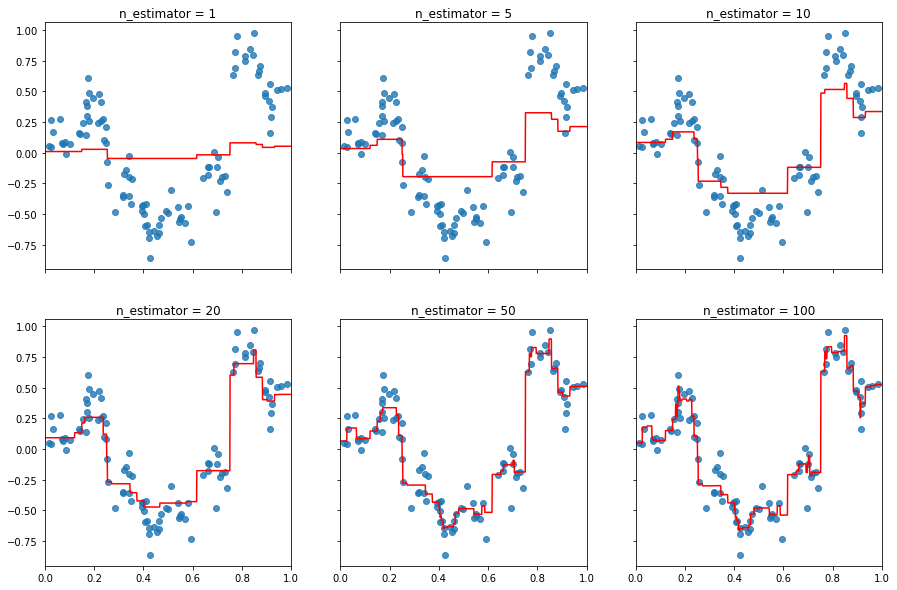

In [32]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = gradient_boosting(n_estimator=i, pseudo_residual_func=pseudo_residual_L2, 
                               max_depth=3, learning_rate=0.1)  
    gbm_1d.fit(x_krr_train, y_krr_train[:,0])
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)


# Comparison with Sklearn GBM

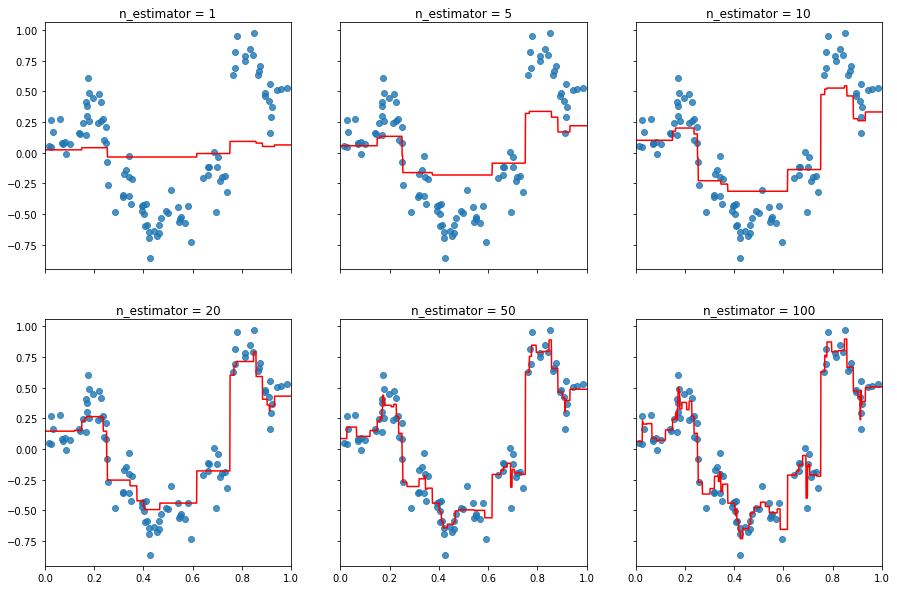

In [33]:
plot_size = 0.001
x_range = np.arange(0., 1., plot_size).reshape(-1, 1)

f2, axarr2 = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(15, 10))

for idx, i, tt in zip(product([0, 1], [0, 1, 2]),
                       [1, 5, 10, 20, 50, 100], 
                       ['n_estimator = {}'.format(n) for n in [1, 5, 10, 20, 50, 100]]):
    
    gbm_1d = GradientBoostingRegressor(loss='ls', n_estimators=i, min_samples_split=5) # least squares regression
    gbm_1d.fit(x_krr_train, y_krr_train[:,0])
    
    y_range_predict = gbm_1d.predict(x_range)

    axarr2[idx[0], idx[1]].plot(x_range, y_range_predict, color='r')
    axarr2[idx[0], idx[1]].scatter(x_krr_train, y_krr_train, alpha=0.8)
    axarr2[idx[0], idx[1]].set_title(tt)
    axarr2[idx[0], idx[1]].set_xlim(0, 1)

# Q7

Give the expression of the negative gradient step direction, or pseudo residual, $-g_m$ for the logistic loss as a function of the prediction function $f_{m-1}$ at the previous iteration and the dataset points $\{(x_i, y_i)\}_{i=1}^n$

- Solution:
$$ g_m = \left(\frac{\partial \sum_{i=1}^n \mathscr{l}(y_i, f_{m-1}(x_i))}{\partial f_{m-1}(x_j)}\right)_{j=1}^n $$

$$ g_m = \left(\frac{\partial \ln(1+e^{-y_i f_{m-1}\,\,(x_i)})}{\partial f_{m-1}(x_j)}\right)_{j=1}^n$$

$$ g_m = \left(\frac{-y_i e^{-y_if_{m-1}\,\,(x_i)}}{1+e^{-y_if_{m-1}\,\,(x_i)}}\right)_{i=1}^n $$

# Q8

Write an expression for h_m as an argmin over functions h in $\mathcal{F}$

- Solution:
$$h_m = argmin_{h\in\mathcal{F}} \sum_{i=1}^n \left((-g_m)_i \,-\,h(x_i) \right)^2$$

$$h_m = argmin_{h\in\mathcal{F}} \sum_{i=1}^n \left(\frac{y_i e^{-y_if_{m-1}\,\,(x_i)}}{1+e^{-y_if_{m-1}\,\,(x_i)}} \,-\,h(x_i) \right)^2$$

# Q9

# Sklearn implementation for Classification of images

In [34]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score

In [43]:
def pre_process_mnist_01():
    """
    Load the mnist datasets, selects the classes 0 and 1 
    and normalize the data.
    Args: none
    Outputs: 
        X_train: np.array of size (n_training_samples, n_features)
        X_test: np.array of size (n_test_samples, n_features)
        y_train: np.array of size (n_training_samples)
        y_test: np.array of size (n_test_samples)
    """
    print('Start Fetching')
    X_mnist, y_mnist = fetch_openml('mnist_784', version=1, 
                                    return_X_y=True, as_frame=False)
    print('Fetch Successfully')
    indicator_01 = (y_mnist == '0') + (y_mnist == '1') 
    X_mnist_01 = X_mnist[indicator_01]
    y_mnist_01 = y_mnist[indicator_01]
    X_train, X_test, y_train, y_test = train_test_split(X_mnist_01, y_mnist_01,
                                                        test_size=0.33,
                                                        shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train) 
    X_test = scaler.transform(X_test)

    y_test = 2 * np.array([int(y) for y in y_test]) - 1
    y_train = 2 * np.array([int(y) for y in y_train]) - 1
    return X_train, X_test, y_train, y_test

In [44]:
X_train, X_test, y_train, y_test = pre_process_mnist_01()

Start Fetching
Fetch Successfully


In [45]:
max_depth = 3
n_estimators = [2, 5, 10, 100, 200]

train_acc_lst = []
test_acc_lst = []

for n in n_estimators:
    clf = GradientBoostingClassifier(loss='deviance', max_depth=max_depth, n_estimators=n).fit(X_train, y_train)
    
    train_pred = clf.predict(X_train)
    train_acc_lst.append(accuracy_score(y_train, train_pred))
    
    test_pred = clf.predict(X_test)
    test_acc_lst.append(accuracy_score(y_test, test_pred))

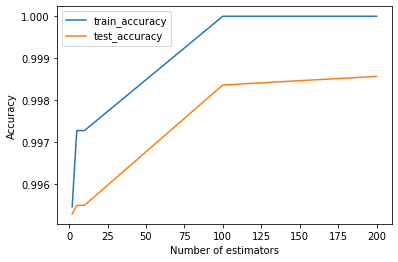

In [46]:
plt.plot(n_estimators, train_acc_lst, label='train_accuracy');
plt.plot(n_estimators, test_acc_lst, label='test_accuracy');
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.legend()

# Q10

Explain the construction principle of random forests.

- The Random Forests is generally one type of ensemble method using bagged decision tree, but modify the tree-growing procedure to reduce the dependence between trees.
- To elaborate, the shortcoming of bagging is obvious: though bagging benefit from reducing variance without making bias worse by averaging the prediction result, it can suffer from bootstrapping, considering the fact that the bootstrap samples are not independent samples from Pxy, which limit the benefit of averaging when n (number of trees) gets large. 
- The Random Forests is thus raised up to solve this 'independence' trouble. When constructing each tree node, this method restrict the choice of splitting variable to a randomly chosen subset of features, in this way effectively reducing the dependence between trees. 

# Q11


In [47]:
max_depth = 3
n_estimators = [2, 5, 10, 50, 100, 200]

train_acc_lst = []
test_acc_lst = []

for n in n_estimators:
    clf = RandomForestClassifier(criterion='entropy', max_depth=max_depth, n_estimators=n).fit(X_train, y_train)
    
    train_pred = clf.predict(X_train)
    train_acc_lst.append(accuracy_score(y_train, train_pred))
    
    test_pred = clf.predict(X_test)
    test_acc_lst.append(accuracy_score(y_test, test_pred))

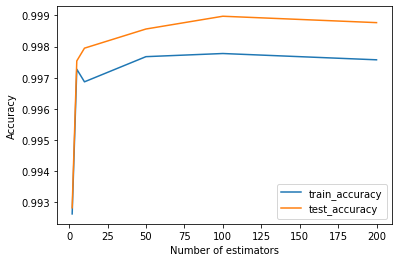

In [48]:
plt.plot(n_estimators, train_acc_lst, label='train_accuracy');
plt.plot(n_estimators, test_acc_lst, label='test_accuracy');
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.legend()

# Q12
Question:
- What general remark can you make on overfitting for Random Forests and Gradient Boosted Trees? Which method achieves the best train accuracy overall? 
- Is this result expected? 
- Can you think of a practical disadvantages of the best performing method? 
- How do the algorithms compare in term of test accuracy?

Solution:

- The Gradient Boosted Trees overfit much more heavily compared with the Random Forest, but it achieve the best train accuracy overall. 
- This result is expected. First, to analyze the overfitting result: the Random Forest split its nodes by randomly selecting the splitting features and thus effectively reduce the dependence of the decision trees. Less variance of the prediction would mean less chance to overfit. Second, to analyze the train accuracy result: the Gradient Boosted Trees work sequentially, always focusing on the points that are misclassified in earlier training process, which induces higher training accuracy at the risk of overfitting.
- In practice, the Gradient Boosted Trees cannot be run parallel, thus requiring more time to train sequentially. 
- The Random Forests achieve the best test accuracy overall, showing its ability to generalize. 